In [2]:
import pandas as pd
import numpy as np
import ConfigParser, os
import seaborn as sea
import matplotlib.pyplot as plt

sea.set(font_scale=2)  # crazy big

%matplotlib inline

def df_mensajes_log_a_df(patron, nombrearchivo):
    mensajes = !grep '$patron' $nombrearchivo
    qss_mensajes = pd.DataFrame([val.split(' / ') for val in mensajes])
    return qss_mensajes

def obtener_patrones(nombrearchivo):
    patrones = ! awk ' { print $1 " " $2 " " $3 " " $4 " " $5 } ' $nombrearchivo  | sort -u
    return patrones

def nombres_modelos(logfile_name):    
    logdir_name = os.path.dirname(logfile_name)
    config = ConfigParser.ConfigParser()
    config.readfp(open(logfile_name))
    
    fn_parallelroot = config.get('logfiles', 'parallelroot')
    fn_top = config.get('logfiles', 'top')

    atomics = { mod_name: os.path.join(logdir_name, fn_mod) for (mod_name, fn_mod) 
               in config.items('logfiles')}
               #if mod_name not in ("top", "parallelroot")}
    return atomics

Mapeamos el archivo de logs para parallelRoot, topLevel y listamos todos los otros modelos.

Vamos a procesar los mensajes Y, recordemos del libro de Wainer:
* messages signal the occurrence of internal events.
* X messages carry information about external input events.
* Y messages transmit the model’s output events.
* done messages carry scheduling information for future events, indicating that a model has finished with its current task.


In [3]:
logs = []
log_dir = os.path.join('logs', 'qss1', 'teacup')
head_log = os.path.join(log_dir, 'log')
info_atomicos = nombres_modelos(head_log)

In [4]:
info_atomicos


{'fm': 'logs/qss1/teacup/log04',
 'fp': 'logs/qss1/teacup/log03',
 'ft': 'logs/qss1/teacup/log02',
 'int': 'logs/qss1/teacup/log01',
 'parallelroot': 'logs/qss1/teacup/log00',
 'top': 'logs/qss1/teacup/log05'}

In [5]:
#{ modelo: {mensajes X: dataframe, mensajes Y: dataframe}}
modelos = {}
patrones = ['0 / L / X', 
            '0 / L / @',
            '0 / L / \*',
            '0 / L / D',
            '0 / L / I',
            '0 / L / Y']

for nombre_atomico, archivo_log in info_atomicos.items():
    for patron in patrones:
        modelos[nombre_atomico] = modelos.get(nombre_atomico, {patron: None})
        modelos[nombre_atomico][patron] = df_mensajes_log_a_df(patron, archivo_log)

In [6]:
modelos

{'fm': {'0 / L / @':      0  1  2                         3        4       5
  0    0  L  @            00:00:00:000:0  top(05)  fm(04)
  1    0  L  @            00:00:00:800:0  top(05)  fm(04)
  2    0  L  @  00:00:08:720:6.10352e-05  top(05)  fm(04)
  3    0  L  @     00:00:17:242:0.608826  top(05)  fm(04)
  4    0  L  @     00:00:26:474:0.758911  top(05)  fm(04)
  5    0  L  @     00:00:36:554:0.570961  top(05)  fm(04)
  6    0  L  @     00:00:47:664:0.785194  top(05)  fm(04)
  7    0  L  @     00:01:00:054:0.303932  top(05)  fm(04)
  8    0  L  @      00:01:14:074:0.50943  top(05)  fm(04)
  9    0  L  @     00:01:30:244:0.475174  top(05)  fm(04)
  10   0  L  @     00:01:49:377:0.852249  top(05)  fm(04)
  11   0  L  @      00:02:12:857:0.77742  top(05)  fm(04)
  12   0  L  @    00:02:43:330:0.0388336  top(05)  fm(04)
  13   0  L  @      00:03:26:912:0.18837  top(05)  fm(04)
  14   0  L  @   00:06:43:990:0.00868225  top(05)  fm(04)
  15   0  L  @     00:22:23:171:0.352432  top(05)  fm

# Heatmap de cantidad de mensajes enviados por modelo para Teacup.

Text(0.5,1,u'Cantidad de eventos por modelo \nescala lineal Modelo Teacup')

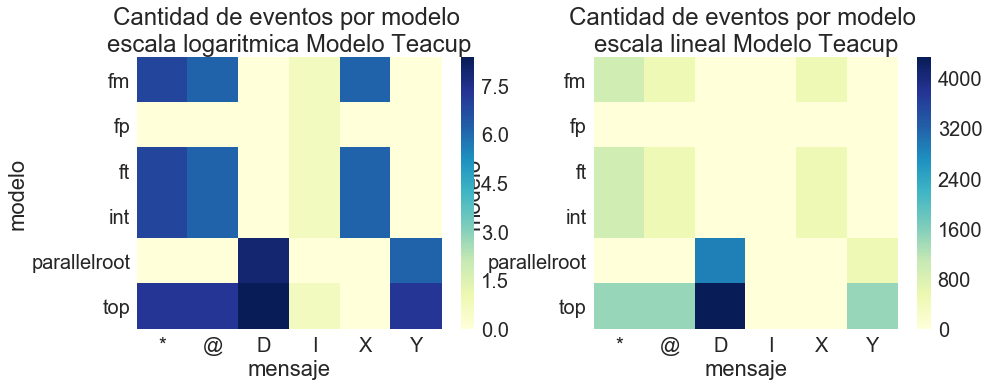

In [7]:
from matplotlib.colors import LogNorm
dataframes = []

for k, v in modelos.items():
    for kk, vv in v.items():
        dataframes.append(pd.DataFrame({'modelo': k, 'mensaje': kk[-1], 'cantidad': len(vv)}, index=[0]))

sumarizado_mensajes = pd.concat(dataframes)
sumarizado_mensajes['log_cantidad'] = np.log(sumarizado_mensajes.cantidad + 1)

sum_msgs_log = sumarizado_mensajes.pivot('modelo', 'mensaje', 'log_cantidad')
sum_msgs = sumarizado_mensajes.pivot('modelo', 'mensaje', 'cantidad')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
sea.heatmap(sum_msgs_log, cmap="YlGnBu", ax=ax1)
sea.heatmap(sum_msgs, cmap="YlGnBu",ax=ax2)
ax1.set_title('Cantidad de eventos por modelo \nescala logaritmica Modelo Teacup')
ax2.set_title('Cantidad de eventos por modelo \nescala lineal Modelo Teacup')


In [9]:
salidas = modelos['top']['0 / L / Y']

aux = salidas[6].str.replace(']', '')
aux2 = aux.str.replace('[', '')
salidas['valor_out'] = pd.to_numeric(aux2)

salidas_int = salidas[salidas[4] == 'int(01)']
salidas_int['x'] = range(0, np.shape(salidas_int)[0])

AttributeError: 'module' object has no attribute 'to_numeric'

In [10]:
pd.__file__

'/home/danito/.local/lib/python2.7/site-packages/pandas/__init__.pyc'

In [65]:
del salidas[3]
del salidas[5]

del salidas[6]
del salidas[7]

salidas.columns = ['id','tipo','evento', 'modelo', 'valor_out']

NameError: name 'salidas_int' is not defined

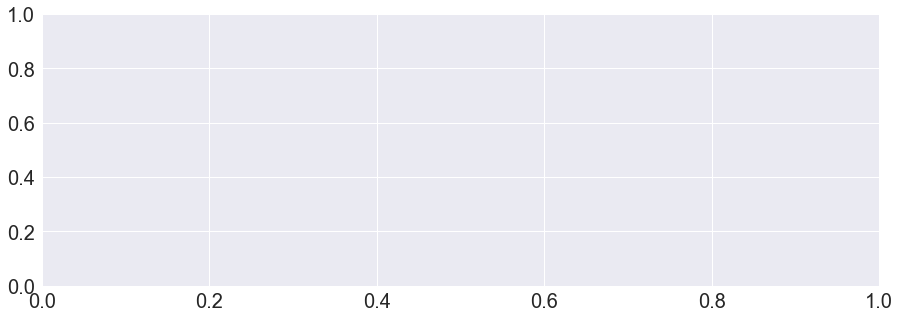

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
salidas_int['valor_out'].plot()

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

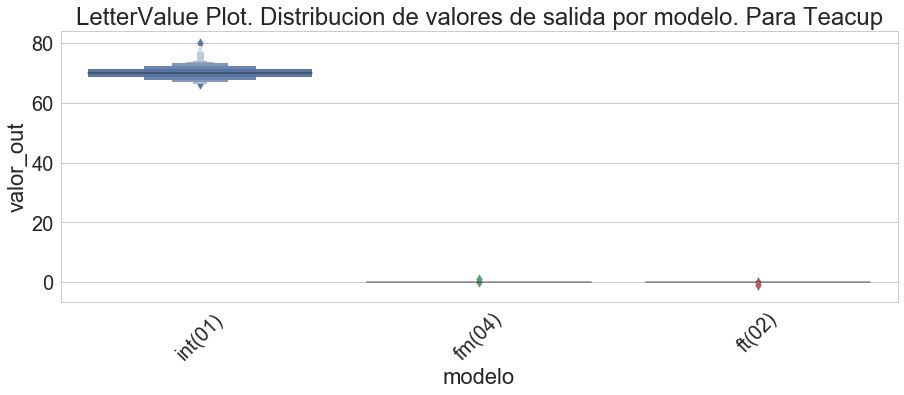

In [301]:
sea.set_style("whitegrid")

salidas['valor_out'] = pd.to_numeric(salidas['valor_out'])
fig, ax = plt.subplots(figsize=(15,5))
g= sea.lvplot(data=salidas, x='modelo', y='valor_out', ax=ax)
ax.set_title('LetterValue Plot. Distribucion de valores de salida por modelo. Para Teacup')
#g.set_xticklabels(rotation=30)

plt.xticks(rotation=45)

# Heatmap para modelo lotka-volterra escala logarítmica.

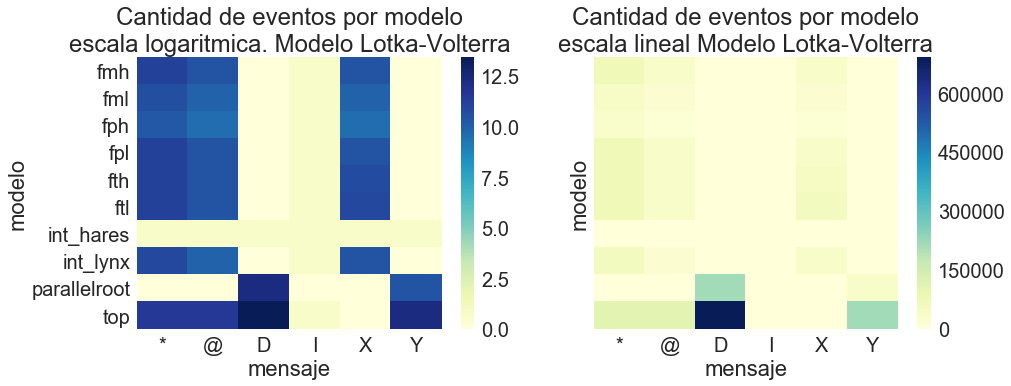

In [76]:
logs = []
log_dir = os.path.join('logs', 'qss1', 'lotka-volterra', 'corrida1_lotkavolterra')
head_log = os.path.join(log_dir, 'log')
info_atomicos = nombres_modelos(head_log)

for log_file in os.listdir(log_dir):
    if str.startswith(log_file, 'log'):
        logs.append(log_file)

modelos = {}
for nombre_atomico, archivo_log in info_atomicos.items():
    for patron in patrones:
        modelos[nombre_atomico] = modelos.get(nombre_atomico, {patron: None})
        modelos[nombre_atomico][patron] = df_mensajes_log_a_df(patron, archivo_log)
        
        dataframes = []

for k, v in modelos.items():
    for kk, vv in v.items():
        dataframes.append(pd.DataFrame({'modelo': k, 'mensaje': kk[-1], 'cantidad': len(vv)}, index=[0]))


sumarizado_mensajes = pd.concat(dataframes)
sumarizado_mensajes['log_cantidad'] = np.log(sumarizado_mensajes.cantidad + 1)

sum_msgs_log = sumarizado_mensajes.pivot('modelo', 'mensaje', 'log_cantidad')
sum_msgs = sumarizado_mensajes.pivot('modelo', 'mensaje', 'cantidad')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
sea.heatmap(sum_msgs_log, cmap="YlGnBu", ax=ax1)
sea.heatmap(sum_msgs, cmap="YlGnBu",ax=ax2)
ax1.set_title('Cantidad de eventos por modelo\nescala logaritmica. Modelo Lotka-Volterra')
ax2.set_title('Cantidad de eventos por modelo\nescala lineal Modelo Lotka-Volterra')

In [77]:
salidas = modelos['top']['0 / L / Y']

In [83]:
aux = salidas[6].str.replace(']', '')
aux2 = aux.str.replace('[', '')
salidas['valor_out'] = pd.to_numeric(aux2)


del salidas[3]
del salidas[5]
del salidas[6]
del salidas[7]

salidas.columns = ['id','tipo','evento', 'modelo', 'valor_out']

In [124]:
liebres = salidas[salidas['modelo'] == 'int_hares(01)'].copy()
linces = salidas[salidas['modelo'] == 'int_lynx(02)'].copy()

linces['x'] = range(0, np.shape(linces)[0])
liebres['x'] = range(0, np.shape(liebres)[0])

lyl  = pd.concat([linces, liebres])

In [141]:
lyl.plot?

In [1]:
fig, ax = plt.subplots(figsize=(15,5))
lyl[lyl.x < 5000].plot(x='x', y='valor_out', ax=ax, kind='scatter')



NameError: name 'plt' is not defined

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

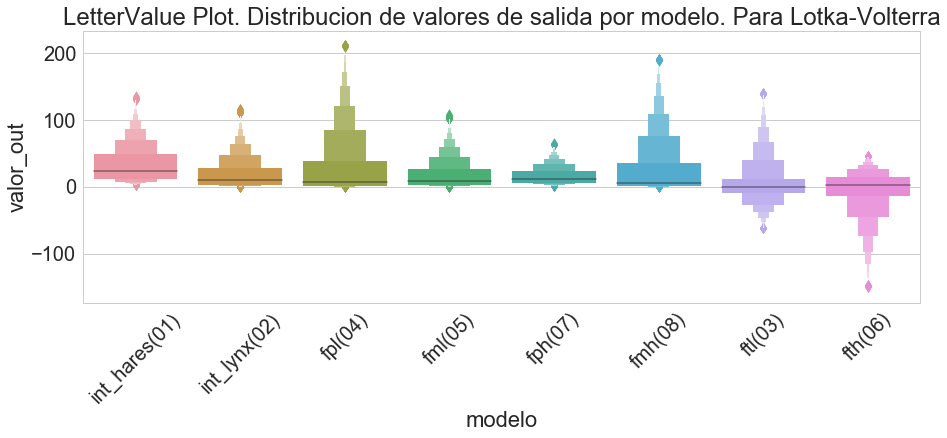

In [291]:
sea.set_style("whitegrid")

salidas['valor_out'] = pd.to_numeric(salidas['valor_out'])
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title('LetterValue Plot. Distribucion de valores de salida por modelo. Para Lotka-Volterra')
g= sea.lvplot(data=salidas, x='modelo', y='valor_out', ax=ax)
#g.set_xticklabels(rotation=30)

plt.xticks(rotation=45)

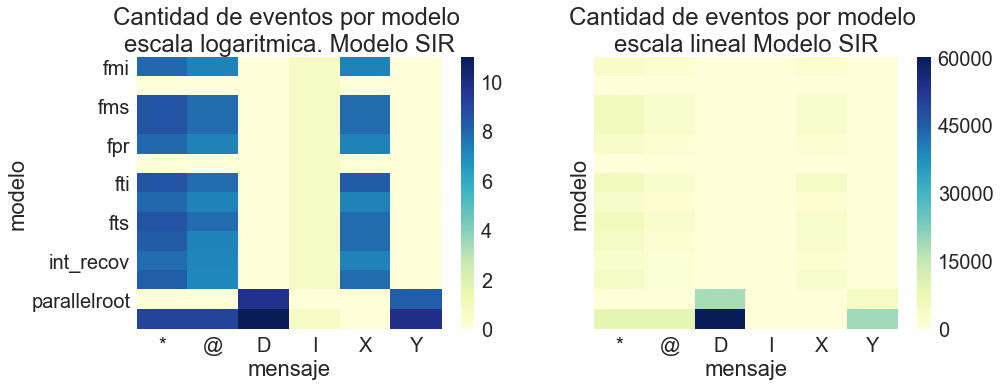

In [146]:
logs = []
log_dir = os.path.join('logs', 'qss1', 'SIR')
head_log = os.path.join(log_dir, 'log')
info_atomicos = nombres_modelos(head_log)

for log_file in os.listdir(log_dir):
    if str.startswith(log_file, 'log'):
        logs.append(log_file)

modelos = {}
for nombre_atomico, archivo_log in info_atomicos.items():
    for patron in patrones:
        modelos[nombre_atomico] = modelos.get(nombre_atomico, {patron: None})
        modelos[nombre_atomico][patron] = df_mensajes_log_a_df(patron, archivo_log)
        
        dataframes = []

for k, v in modelos.items():
    for kk, vv in v.items():
        dataframes.append(pd.DataFrame({'modelo': k, 'mensaje': kk[-1], 'cantidad': len(vv)}, index=[0]))


sumarizado_mensajes = pd.concat(dataframes)
sumarizado_mensajes['log_cantidad'] = np.log(sumarizado_mensajes.cantidad + 1)

sum_msgs_log = sumarizado_mensajes.pivot('modelo', 'mensaje', 'log_cantidad')
sum_msgs = sumarizado_mensajes.pivot('modelo', 'mensaje', 'cantidad')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
sea.heatmap(sum_msgs_log, cmap="YlGnBu", ax=ax1)
sea.heatmap(sum_msgs, cmap="YlGnBu",ax=ax2)
ax1.set_title('Cantidad de eventos por modelo \nescala logaritmica. Modelo SIR')
ax2.set_title('Cantidad de eventos por modelo \nescala lineal Modelo SIR')

In [147]:
salidas = modelos['top']['0 / L / Y']

aux = salidas[6].str.replace(']', '')
aux2 = aux.str.replace('[', '')
salidas['valor_out'] = pd.to_numeric(aux2)


del salidas[3]
del salidas[5]
del salidas[6]
del salidas[7]

salidas.columns = ['id','tipo','evento', 'modelo', 'valor_out']

In [152]:
salidas.head()

,id,tipo,evento,modelo,valor_out
0,0,L,Y,int_susc(01),1000.0000
1,0,L,Y,int_inf(02),5.0000
2,0,L,Y,int_recov(03),0.0000
3,0,L,Y,fms(06),16.6667
4,0,L,Y,fpi(08),16.6667


In [167]:
susc = salidas[salidas['modelo'] == 'int_susc(01)'].copy()
inf = salidas[salidas['modelo'] == 'int_inf(02)'].copy()
recov = salidas[salidas['modelo'] == 'int_recov(03)'].copy()

susc['x'] = range(0, np.shape(susc)[0])
inf['x'] = range(0, np.shape(inf)[0])
recov['x'] = range(0, np.shape(recov)[0])

sir  = pd.concat([susc, inf, recov])


,id,tipo,evento,modelo,valor_out,x
3157,0,L,Y,int_susc(01),904.38200,10
303,0,L,Y,int_inf(02),5.52311,10
19,0,L,Y,int_recov(03),0.00100,10


/home/danito/facu/sed_2017/sed_2017_tps/python_notebooks


/home/danito/ambientes/py2_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


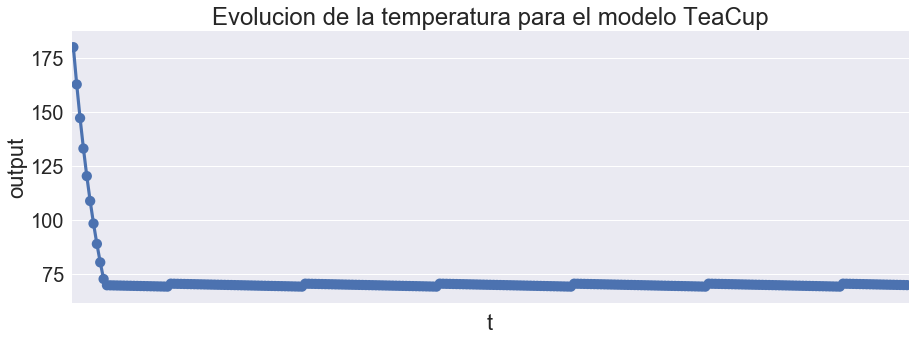

In [2]:

p = pd.read_csv('salidas_sd/teacup/outputCharacteristicTime0.1FinalTime30Mins', sep='\t+', names=['t', 'type', 'output'])
p.t = pd.to_datetime(p.t, format='%H:%M:%S:%f')
p_sample = p.iloc[range(0, p.shape[0], 10),:]
p_s_mean = p_sample.groupby(['t', 'type']).mean().reset_index()

plt.figure(figsize=(15,5))
g=sea.pointplot(data=p_s_mean, x='t', y='output', hue='type')
g.set(xticklabels=[])
g.set_title('Evolucion de la temperatura para el modelo TeaCup')
g.legend_.remove()

In [50]:
p.head(100)

,t,type,output
0,1900-01-01 00:00:00.000,outteacuptemperature,180.0000
1,1900-01-01 00:00:00.001,outteacuptemperature,178.2000
2,1900-01-01 00:00:00.003,outteacuptemperature,176.4180
3,1900-01-01 00:00:00.004,outteacuptemperature,174.6540
4,1900-01-01 00:00:00.006,outteacuptemperature,172.9070
5,1900-01-01 00:00:00.008,outteacuptemperature,171.1780
6,1900-01-01 00:00:00.009,outteacuptemperature,169.4660
7,1900-01-01 00:00:00.011,outteacuptemperature,167.7720
8,1900-01-01 00:00:00.013,outteacuptemperature,166.0940
9,1900-01-01 00:00:00.015,outteacuptemperature,164.4330


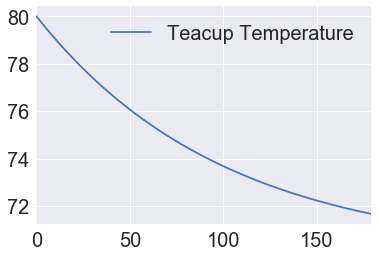

In [47]:
sd_model = pd.read_csv('modelos-ds/teacup/teacup_sd.csv')
sd_model.iloc[:,4:].plot()

In [37]:
sd_model

,Unnamed: 0,Characteristic Time,Heat Loss to Room,Room Temperature,Teacup Temperature
0,0,100,0.100000,70,80.000000
1,1,100,0.099004,70,79.900436
2,2,100,0.098019,70,79.801864
3,3,100,0.097043,70,79.704273
4,4,100,0.096077,70,79.607654
5,5,100,0.095120,70,79.511997
6,6,100,0.094173,70,79.417292
7,7,100,0.093235,70,79.323530
8,8,100,0.092307,70,79.230702
9,9,100,0.091388,70,79.138797


In [3]:
sd_model = pd.read_csv('modelos-ds/SIR/sir_sd.csv')
sd_model.head().to_clipboard()

In [41]:
sd_model.head()

,Unnamed: 0,Contact Infectivity,Duration,Infectious,Recovered,Recovering,Succumbing,Susceptible,Total Population
0,0.000,0.3,5,5.000000,0.000000,1.000000,1.500000,1000.000000,1000
1,0.125,0.3,5,5.062780,0.125587,1.012556,1.518548,999.811633,1000
2,0.250,0.3,5,5.126312,0.252751,1.025262,1.537311,999.620937,1000
3,0.375,0.3,5,5.190605,0.381510,1.038121,1.556291,999.427885,1000
4,0.500,0.3,5,5.255665,0.511883,1.051133,1.575489,999.232451,1000


In [44]:
(sd_model.Recovered + sd_model.Susceptible + sd_model.Infectious).head().to_clipboard()

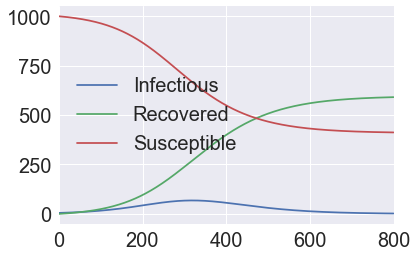

In [4]:
sd_model.iloc[:, [3,4,7]].plot()


/home/danito/ambientes/py2_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Text(0.5,1,u'Evolucion del modelo SIR')

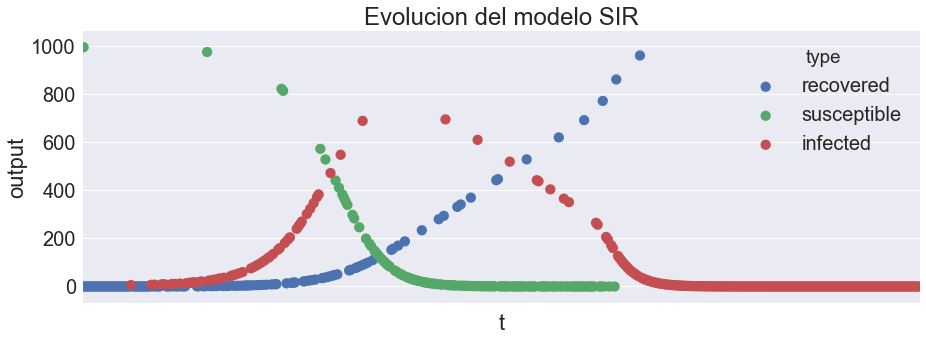

In [83]:

p = pd.read_csv('nuevos_logs/sir//output', sep='\t+', names=['t', 'type', 'output'])

p.t = pd.to_datetime(p.t, format='%H:%M:%S:%f')


p_sample = p.iloc[range(0, p.shape[0], 10),:]
p_s_mean = p_sample.groupby(['t', 'type']).mean().reset_index()

plt.figure(figsize=(15,5))
g=sea.pointplot(data=p_s_mean, x='t', y='output', hue='type')
g.set(xticklabels=[])
g.set_title('Evolucion del modelo SIR')


In [90]:
p = pd.read_csv('nuevos_logs/lotka-volterra/output', sep='\t+', names=['t', 'type', 'output'])

/home/danito/ambientes/py2_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


Text(0.5,1,u'Evolucion del modelo LotkaVolterra')

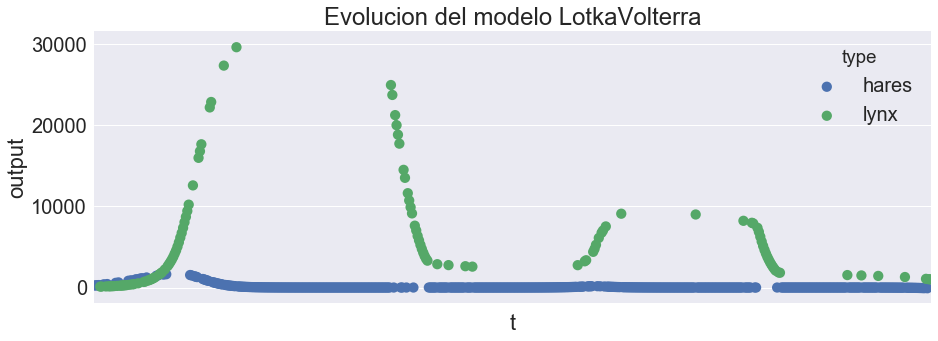

In [93]:
#p.t = pd.to_datetime(p.t, format='%H:%M:%S:%f')


p_sample = p.iloc[range(0, p.shape[0], 10),:]
p_s_mean = p_sample.groupby(['t', 'type']).mean().reset_index()

plt.figure(figsize=(15,5))
g=sea.pointplot(data=p_s_mean, x='t', y='output', hue='type')
g.set(xticklabels=[])
g.set_title('Evolucion del modelo LotkaVolterra')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

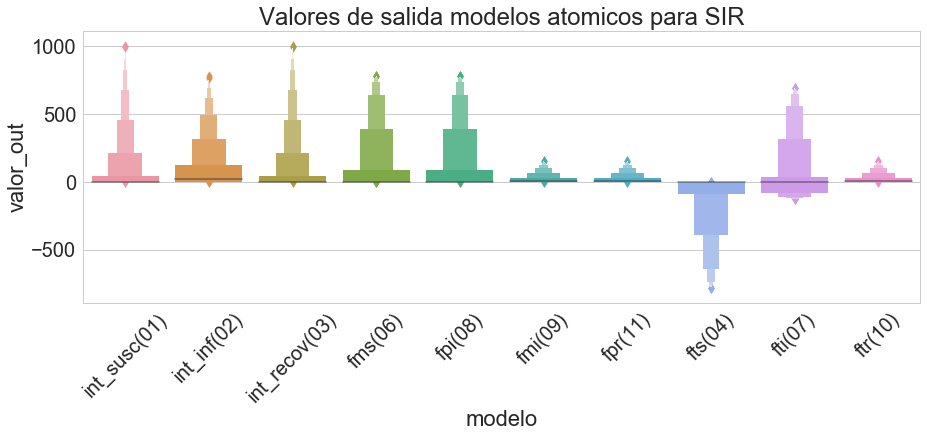

In [284]:
sea.set_style("whitegrid")

salidas['valor_out'] = pd.to_numeric(salidas['valor_out'])
fig, ax = plt.subplots(figsize=(15,5))
g= sea.lvplot(data=salidas, x='modelo', y='valor_out', ax=ax)
#g.set_xticklabels(rotation=30)
ax.set_title('Valores de salida modelos atomicos para SIR')

plt.xticks(rotation=45)